In [32]:
## Load packages
import sys
import torch
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import clear_output

from tumorpde.models.deform import TumorDeformFD
from tumorpde.volume_domain import VolumeDomain
from tumorpde.models._base import default_init_density, default_init_density_deriv

# Ensure the proper device is used
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
torch.set_default_device(device)

In [31]:
import importlib
importlib.reload(sys.modules['tumorpde._typing'])
importlib.reload(sys.modules['tumorpde.models._base'])
importlib.reload(sys.modules['tumorpde.models.comp_utils'])
importlib.reload(sys.modules['tumorpde.models.deform'])
importlib.reload(sys.modules['tumorpde.volume_domain'])

<module 'tumorpde.volume_domain' from '/home/muye/Projects/2024_01_BrainTumorDiffusion/TumorPDE/tumorpde/volume_domain.py'>

## Data Generation

In [18]:
# define the grid of the spatial domain 
dx = 0.1
x_range = (0., 10.)
nx = int((x_range[1] - x_range[0]) / dx + 1)
x_grid = np.linspace(x_range[0], x_range[1], nx)

# define a domain mask
domain_interval = np.logical_and(x_grid >= 1., x_grid <= 9.)
domain_mask = np.zeros_like(x_grid) + 1. * domain_interval
fake_gm = np.zeros_like(x_grid) + \
    (0.2 + np.sin(np.pi * (x_grid - 2.))) * np.logical_and(x_grid >= 2., x_grid <= 3.) + \
    (0.2 + np.sin(np.pi * (x_grid - 7.))) * np.logical_and(x_grid >= 7., x_grid <= 8.) + \
    (0.1 + np.sin(2 * np.pi * (x_grid - 3.5))) * np.logical_and(x_grid >= 3.5, x_grid <= 4.) + \
    (0.1 + np.sin(2 * np.pi * (x_grid - 6.))) * np.logical_and(x_grid >= 6., x_grid <= 6.5)
fake_wm = np.zeros_like(x_grid) + \
    (0.1 + np.sin(np.pi * (x_grid - 2.5) / 2.)) * np.logical_and(x_grid >= 2.5, x_grid <= 4.5) + \
    (0.1 + np.sin(np.pi * (x_grid - 5.5) / 2.)) * np.logical_and(x_grid >= 5.5, x_grid <= 7.5)
fake_csf = np.zeros_like(x_grid) + \
    (0.05 + 0.1 * np.sin(np.pi * (x_grid - 4.) / 2)) * np.logical_and(x_grid >= 4., x_grid <= 6.) + \
    (0.05 + 0.1 * np.sin(np.pi * (x_grid - 1.) / 2)) * np.logical_and(x_grid >= 1., x_grid <= 3.) + \
    (0.05 + 0.1 * np.sin(np.pi * (x_grid - 7.) / 2)) * np.logical_and(x_grid >= 7., x_grid <= 9.)

geom = VolumeDomain(domain_mask, voxel_widths=[dx])
t0, t1 = (0., 1.)

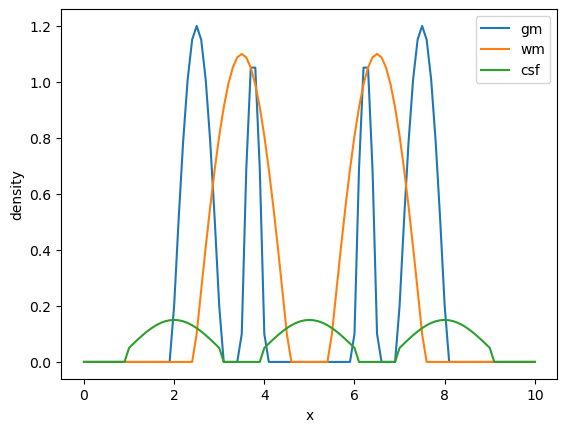

In [19]:
plt.figure()
plt.plot(x_grid, fake_gm, label='gm')
plt.plot(x_grid, fake_wm, label='wm')
plt.plot(x_grid, fake_csf, label='csf')
# plt.plot(x_grid, fake_gm + fake_wm + fake_csf, label='sum')
plt.legend()
plt.xlabel('x')
plt.ylabel('density')
plt.show()

In [20]:
matters = torch.cat([
    torch.tensor(fake_gm, device=device).unsqueeze(0),
    torch.tensor(fake_wm, device=device).unsqueeze(0),
    torch.tensor(fake_csf, device=device).unsqueeze(0)
], dim=0)

In [33]:
# randomly set up the parameters
D = 2.
alpha = 200.
cx = [6.]
M = 1.
kappa = 1.
D_ratio = 0.3
# kappa_ratios = [0.01, 0.1]
kappa_ratios = [0.1, 0.5]
init_peak_height = 0.01
init_peak_width = 0.1
init_density_params = {
  'w': init_peak_width,
  'h': init_peak_height,
  'rmax': 3.*dx
}

# create the PDE model
fd_pde = TumorDeformFD(geom, matters,
                       D, alpha, M, kappa,
                       D_ratio, kappa_ratios,
                       init_learnable_params=cx,
                       init_other_params=init_density_params)

In [34]:
state = fd_pde.init_state(fd_pde.init_params)
params = fd_pde.parameters
dt = 0.00001

In [217]:
fd_pde.forward_update(state, dt, params)

Negative density at rho[0] occured and had been forced to 0.
Negative density at rho[1] occured and had been forced to 0.
Negative density at rho[2] occured and had been forced to 0.


In [35]:
dt = 0.00001
for i in range(1000):
    fd_pde.forward_update(state, dt, params)

Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error


In [307]:
(state.brain_density[0] - matters[0].to(**fd_pde.factory_args)).max()

tensor(0.4616)

In [306]:
state.brain_density[2][90]

tensor(0.0714)

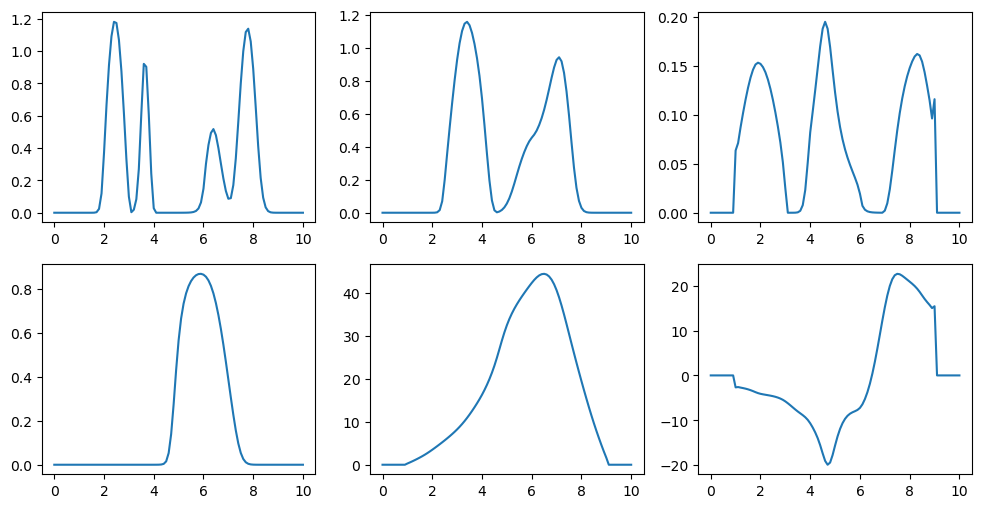

In [30]:
fig, ax = plt.subplots(nrows=2, ncols=3, figsize=(12, 6))
ax[0][0].plot(x_grid, state.brain_density[0].cpu().numpy(),
              label='grey matter')
ax[0][1].plot(x_grid, state.brain_density[1].cpu().numpy(),
              label='white matter')
ax[0][2].plot(x_grid, state.brain_density[2].cpu().numpy(), label='csf')
ax[1][0].plot(x_grid, state.tumor_density.cpu().numpy(), label='tumor density')
ax[1][1].plot(x_grid, state.pressure_field.cpu().numpy(),
              label='tumor density')
ax[1][2].plot(x_grid, state.deform_velocity[0].cpu().numpy(),
              label='grey matter')
plt.show()

Forward Simulation: 100%|██████████| 1000/1000 [00:00<00:00, 8593.63it/s]


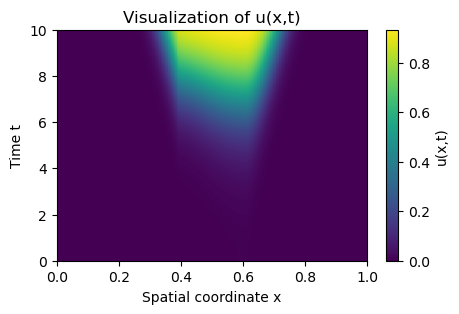

In [57]:
# do a forward run and visualize the solution

u, t, u_hist = fd_pde.solve(dt=0.001, t1=t1, save_all=True)
U = u_hist[-1].clone()  # use the last time step as our observation

def visualize_u(U, t0, t1, x0, x1):
    # Create the heatmap
    plt.figure(figsize=(5, 3))
    plt.imshow(U, extent=[t0, t1, x0, x1], aspect='auto', origin='lower', cmap='viridis')
    plt.colorbar(label='u(x,t)')
    plt.xlabel('Spatial coordinate x')
    plt.ylabel('Time t')
    plt.title('Visualization of u(x,t)')
    plt.show()

visualize_u(u_hist[::10], t.min(), t.max(), x_range[0], x_range[1])

## Solve by Sensitivity Equations

### Single Observation

In [43]:
# use the last time step as our observation
# randomly initialize the parameters
# then calibrate the model

cx_pert = 3. + 5. * np.random.rand(1)
D_pert = D * (0.5 + np.random.rand(1))
rho_pert = rho * (0.5 + np.random.rand(1))
# fd_pde = TumorGrowthFD(
#     geom, x0_pert, D_pert, rho_pert,
#     init_density_params=init_density_params, device=device)
fd_pde = TumorInfiltraFD(
    geom, D_pert, rho_pert, init_learnable_params=cx_pert,
    init_other_params=init_density_params, device=device)
# init_param_tmp = init_density_params
# init_param_tmp['x0'] = torch.as_tensor(cx) 
# fd_pde = TumorInfiltraFD(
#     geom, D_pert, rho_pert,
#     init_density_func=default_init_density,
#     init_density_deriv=default_init_density_deriv,
#     init_other_params=init_density_params,
#     device=device)

fd_pde.check_gradients(obs=U, dt=0.001, t1=t1)


Gradient Check Results:
Max Difference: 0.002312876284122467
Average Difference: 0.0014010302062767248
Gradients:
[-0.0004974  -0.07507245  0.00198323]
Finite Difference Approximations:
[ 0.00011642 -0.07275958  0.00325963]


In [44]:
result = fd_pde.calibrate_model(
    obs=U.to(device), dt=0.001, t1=t1, max_iter=50,
    verbose=True, message_period=1,
    method='L-BFGS-B')
print(f"True parameters: D={D}, rho={rho}, cx={cx}")
print(f"Estimated parameters: D={result['D']:.3f}",
      f"rho={result['rho']:.3f}", f"cx={[round(x.item(), 3) for x in result['x0'].detach()]}")

loss: 0.0033225116785615683,
params: [1.7897584438323975, 8.850689888000488, 6.098000526428223],
grads: [-0.0004974  -0.07507245  0.00198323]
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.32251D-03    |proj g|=  7.50725D-02
loss: 0.0011450554011389613,
params: [1.7906485795974731, 9.515132904052734, 6.077969551086426],
grads: [0.00659662 0.01104187 0.03571224]

At iterate    1    f=  1.14506D-03    |proj g|=  3.57122D-02
loss: 0.0010441095801070333,
params: [1.7830040454864502, 9.521882057189941, 5.839385032653809],
grads: [ 0.00551816  0.00504482 -0.01073839]

At iterate    2    f=  1.04411D-03    |proj g|=  1.07384D-02
loss: 0.0009677318157628179,
params: [1.77957022190094, 9.467020034790039, 5.898784637451172],
grads: [ 0.00495258  0.00017659 -0.00635469]

At iterate    3    f=  9.67732D-04    |proj g|=  6.35469D-03
loss: 0.00090616696979

### Multiple Observations

In [58]:
t_idx_selected = [int(( t.shape[0]-1 ) * 0.7), int(( t.shape[0]-1 ) * 1.)]
t_selected = [t[i] for i in t_idx_selected]
u_selected = u_hist[t_idx_selected]
print(f"Chosen time points: {t_selected}")

Chosen time points: [tensor(0.7000), tensor(1.)]


In [59]:
fd_pde = TumorInfiltraFD(
    geom, D * (0.5 + np.random.rand(1)), rho * (0.5 + np.random.rand(1)),
    init_learnable_params=cx,
    init_other_params=init_density_params, device=device)

In [60]:
result = fd_pde.calibrate_model_multiscan(
    obs=u_selected, dt=0.001, t1=t1, max_iter=30,
    prepare_stage=True, max_iter_prepare=10,
    verbose=True, message_period=1)


print(f"True parameters: D={D}, rho={rho}, cx={cx}, t={t_selected[-1]}")
print(f"Estimated parameters: D={result['D']:.3f}",
      f"rho={result['rho']:.3f}", f"cx={[round(x.item(), 3) for x in result['x0'].detach()]}",
      f"t={[round(t, 3) for t in result['t_scan']]}")

Stage 0: fit the last scan
loss: 0.034580670297145844,
params: [1.359497308731079, 14.049888610839844, 6.000000476837158],
grads: [0.06032862 0.16490507 0.08017736]
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.45807D-02    |proj g|=  1.64905D-01
loss: 0.010795378126204014,
params: [1.2774807214736938, 11.732990264892578, 5.190208911895752],
grads: [ 0.0230453   0.09784711 -0.08773247]

At iterate    1    f=  1.07954D-02    |proj g|=  9.78471D-02
loss: 0.009581584483385086,
params: [1.1865944862365723, 8.630128860473633, 5.599861145019531],
grads: [-0.01187871 -0.20380484 -0.0359777 ]
loss: 0.003181194420903921,
params: [1.2433171272277832, 10.566645622253418, 5.344194412231445],
grads: [ 0.00644291  0.0408379  -0.07596456]

At iterate    2    f=  3.18119D-03    |proj g|=  7.59646D-02
loss: 0.0005473428755067289,
params: [1.2191554307937622,